### Import libraries and cleaned data

In [1]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 6.4 MB/s eta 0:00:00


In [2]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 2.1 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4031 sha256=0c438de82f0fed9557150b39d6c8575c7312af866279a6b44e05b5bf3bb27ad9
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifetimes.utils import summary_data_from_transaction_data
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
file_path = '/content/drive/My Drive/CLV_Data/processed_online_retail_II.csv'

In [6]:
df = pd.read_csv(file_path)

### Customer Segmentation by Total Purchase

In [7]:
df['Total Purchase'].describe()

,Total Purchase
count,400947.000000
mean,21.943633
std,77.755308
min,0.000000
25%,5.000000
50%,12.500000
75%,19.500000
max,15818.400000


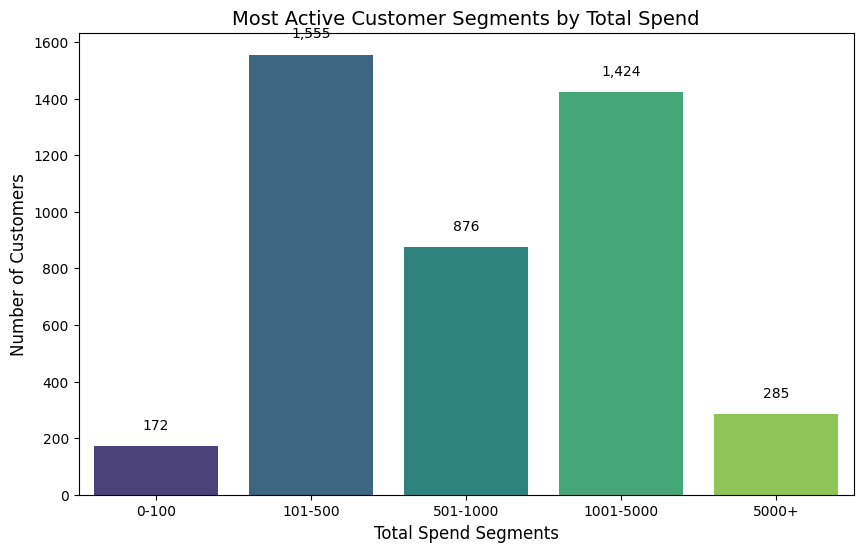

In [8]:
customer_total_spend = df.groupby('Customer ID')['Total Purchase'].sum().sort_values(ascending=False)

# Creating customer segments based on total spend
bins = [0, 100, 500, 1000, 5000, customer_total_spend.max()]
labels = ['0-100', '101-500', '501-1000', '1001-5000', '5000+']
customer_segments = pd.cut(customer_total_spend, bins=bins, labels=labels)
ordered_segments = customer_segments.value_counts().sort_index()

plt.figure(figsize=(10, 6))
palette = sns.color_palette("viridis", len(ordered_segments))
ax = sns.barplot(x=ordered_segments.index, y=ordered_segments.values, palette=palette)
plt.title('Most Active Customer Segments by Total Spend', fontsize=14)
plt.xlabel('Total Spend Segments', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=0, fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 10),
                textcoords = 'offset points', fontsize=10)
plt.show()

The bar chart divides customers based on their total purchase amount.

- The majority of customers fall into the 101-500 spending range, suggesting that the business is either more accessible to those with lower budgets or that these customers typically make small, frequent purchases.
- The 1001-5000 and 501-1000 segments, while smaller in number, might represent a valuable demographic due to their substantial contributions to overall revenue.
- The smallest customer groups are found in the 0-100 and 5000+ segments. Those spending under 100 are likely new or infrequent customers with minimal engagement, while those spending over 5000 consist of premium customers with significant purchase volumes, despite being few.
- Such segmentation helps the business customize its marketing efforts and customer relationship strategies. For example, developing loyalty programs or specific promotions could help transition customers from the '0-100' range to higher spending brackets. For the highest spenders in the '5000+' range, exclusive offers or enhanced services could be used to retain their loyalty and encourage continued spending.
- By examining the buying patterns in these segments, the business could identify popular products and create bundles or promotions aimed at increasing the average spend.

### Customer Segmentation by RFM

#### RFM Estimation - (Recency, Frequency, Monetary)

In [9]:
rfm_summary = lifetimes.utils.summary_data_from_transaction_data(df, "Customer ID", "InvoiceDate", "Total Purchase")
rfm_summary.head()

,frequency,recency,T,monetary_value
Customer ID,,,,
12346.0,6.0,196.0,360.0,47.143333
12347.0,1.0,37.0,39.0,711.790000
12348.0,0.0,0.0,73.0,0.000000
12349.0,2.0,182.0,224.0,801.310000
12351.0,0.0,0.0,10.0,0.000000


In [10]:
rfm_summary['R Score'] = pd.qcut(rfm_summary['recency'], 5, labels=[4, 3, 2, 1], duplicates='drop')
rfm_summary['F Score'] = pd.qcut(rfm_summary['frequency'], 5, labels=[1, 2, 3, 4], duplicates='drop')
rfm_summary['M Score'] = pd.qcut(rfm_summary['monetary_value'], 5, labels=[1, 2, 3, 4], duplicates='drop')

rfm_summary['R Score'] = rfm_summary['R Score'].astype(int)
rfm_summary['F Score'] = rfm_summary['F Score'].astype(int)
rfm_summary['M Score'] = rfm_summary['M Score'].astype(int)

rfm_summary.head(3)

,frequency,recency,T,monetary_value,R Score,F Score,M Score
Customer ID,,,,,,,
12346.0,6.0,196.0,360.0,47.143333,2,4,1
12347.0,1.0,37.0,39.0,711.790000,3,1,4
12348.0,0.0,0.0,73.0,0.000000,4,1,1


In [11]:
rfm_summary['RFM Score'] = (
    rfm_summary['R Score'].astype(str) +
    rfm_summary['F Score'].astype(str) +
    rfm_summary['M Score'].astype(str)
)

rfm_summary.head(2)

,frequency,recency,T,monetary_value,R Score,F Score,M Score,RFM Score
Customer ID,,,,,,,,
12346.0,6.0,196.0,360.0,47.143333,2,4,1,241
12347.0,1.0,37.0,39.0,711.790000,3,1,4,314


In [12]:
segment_map = {
    r'[3-4][3-4][3-4]': 'Champions',  # High R, F, M
    r'1[3-4][3-4]': 'Can’t Lose Them',  # Low R, high F, M
    r'[2-4][2-4][2-4]': 'Loyal Customers',  # Moderate to high R, F, M
    r'[2-3][2-3][2-3]': 'Potential Loyalists',  # Moderate R, F, M
    r'[3-4][1-2][1-2]': 'Recent Customers',  # High R, low F, M
    r'[1-2][2-4][2-4]': 'At-Risk Customers',  # Low R, moderate to high F, M
    r'[1-2][1-2][1-2]': 'Hibernating',  # Low R, F, M
    r'[2-4][1-2][1-2]': 'Price Sensitive',  # Moderate R, low F, M
}

rfm_summary['Segment'] = rfm_summary['RFM Score'].replace(segment_map, regex=True)
rfm_summary['Segment'] = rfm_summary['Segment'].apply(lambda x: 'Not Categorized' if x.isdigit() else x)
rfm_summary.head(6)

,frequency,recency,T,monetary_value,R Score,F Score,M Score,RFM Score,Segment
Customer ID,,,,,,,,,
12346.0,6.0,196.0,360.0,47.143333,2,4,1,241,Not Categorized
12347.0,1.0,37.0,39.0,711.790000,3,1,4,314,Not Categorized
12348.0,0.0,0.0,73.0,0.000000,4,1,1,411,Recent Customers
12349.0,2.0,182.0,224.0,801.310000,2,2,4,224,Loyal Customers
12351.0,0.0,0.0,10.0,0.000000,4,1,1,411,Recent Customers
12352.0,1.0,17.0,27.0,200.050000,4,1,2,412,Recent Customers


In [13]:
rfm_summary.reset_index(inplace=True)

#### RFM Distribution and Boxplot

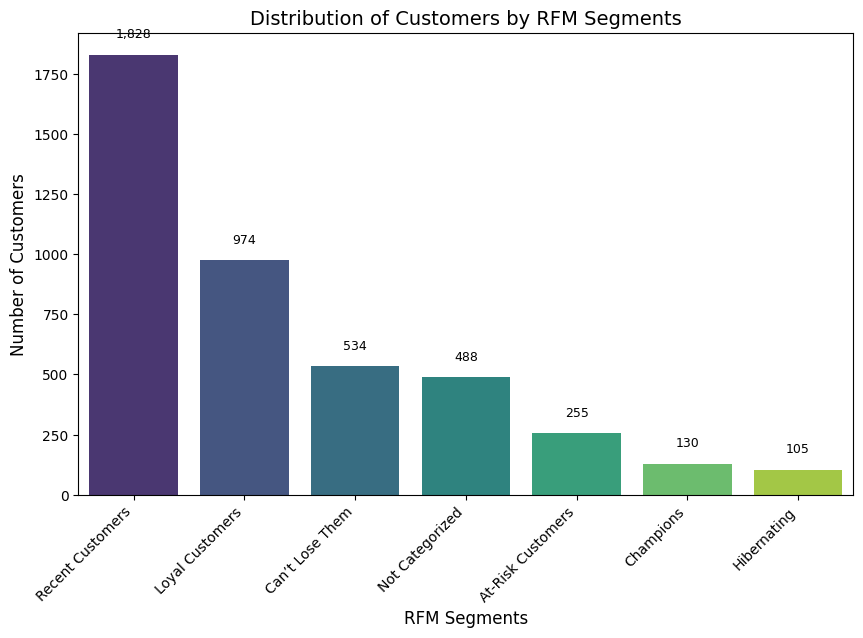

In [14]:
segment_counts = rfm_summary['Segment'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
ax = sns.barplot(x=segment_counts.index, y=segment_counts.values, palette='viridis')
plt.title('Distribution of Customers by RFM Segments', fontsize=14)
plt.xlabel('RFM Segments', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.xticks(rotation=45, ha="right", fontsize=10)

for p in ax.patches:
    ax.annotate(format(p.get_height(), ',.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'bottom',
                xytext = (0, 10),
                textcoords = 'offset points', fontsize=9)

plt.show()

- Dominance of Recent Customers: The largest segment is the 'Recent Customers,' which indicates a significant influx of new or recently active customers. This suggests effective acquisition strategies or recent promotions that have successfully attracted customers.
- The 'Can't Lose Them' segment, although not very large, consists of previously valuable customers who have shown signs of decreased engagement. Strategic focus on these customers through personalized offers or loyalty incentives could be crucial in retaining them.
- Underutilized Potential in Champions: The 'Champions' segment, which comprises customers with high recency, frequency, and monetary scores, is relatively small. This group typically represents the most loyal and highest-spending customers. Growing this segment is necessary to yield significant increases in revenue.

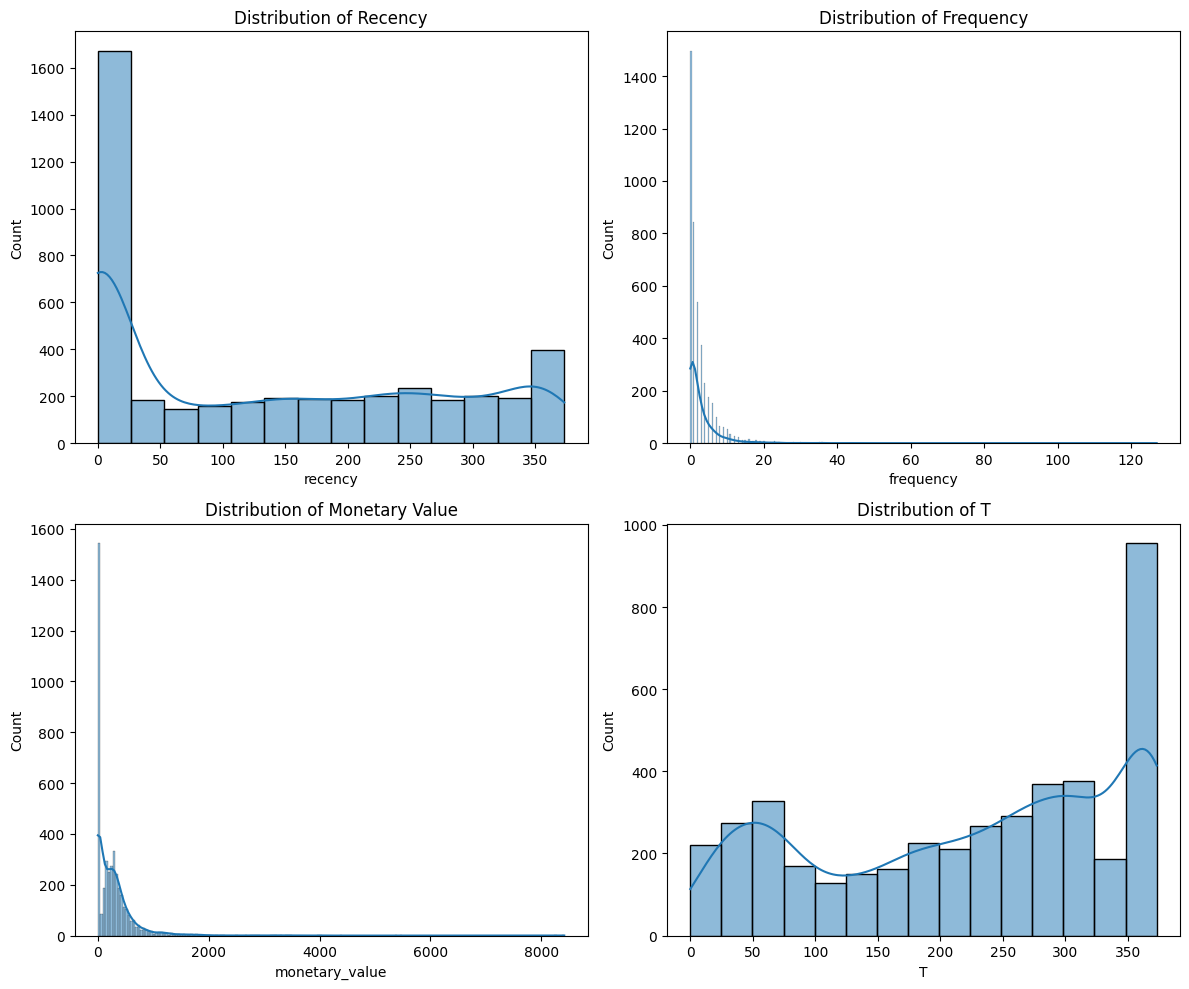

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(data=rfm_summary, x='recency', kde=True, ax=axs[0, 0])
axs[0, 0].set_title('Distribution of Recency')

sns.histplot(data=rfm_summary, x='frequency', kde=True, ax=axs[0, 1])
axs[0, 1].set_title('Distribution of Frequency')

sns.histplot(data=rfm_summary, x='monetary_value', kde=True, ax=axs[1, 0])
axs[1, 0].set_title('Distribution of Monetary Value')

sns.histplot(data=rfm_summary, x='T', kde=True, ax=axs[1, 1])
axs[1, 1].set_title('Distribution of T')

plt.tight_layout()
plt.show()

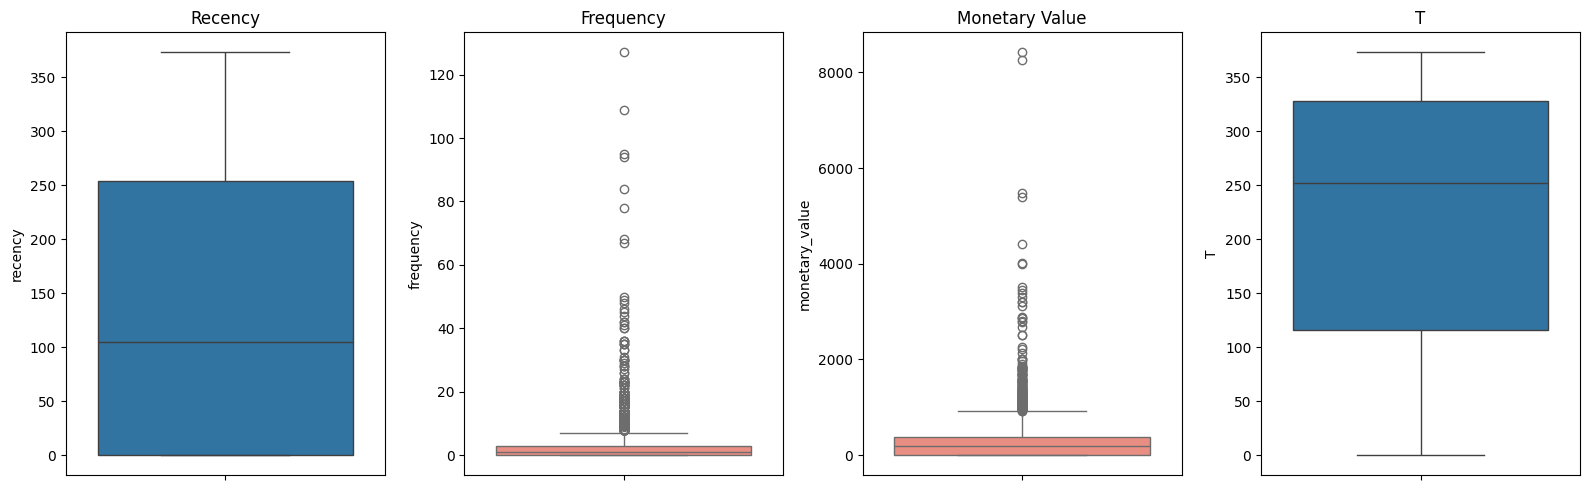

In [16]:
plt.figure(figsize=(16,5))

plt.subplot(141)
sns.boxplot(rfm_summary["recency"])
plt.title("Recency")

plt.subplot(142)
sns.boxplot(rfm_summary["frequency"], color = "salmon")
plt.title("Frequency")

plt.subplot(143)
sns.boxplot(rfm_summary["monetary_value"], color = "salmon")
plt.title("Monetary Value")

plt.subplot(144)
sns.boxplot(rfm_summary["T"])
plt.title("T")

plt.tight_layout()

RFM (Recency, Frequency, Monetary value) and T (Time since first purchase)
- Recency: From the distribution, we can see that majority of customers have engaged recently. The right skew indicates that fewer customers have not interacted for a longer period.
- Frequency: The boxplot shows that most customers have a low frequency of transactions, with a small number having extremely high frequencies. The majority of customers purchase infrequently, as seen in both the histogram's sharp decline and the boxplot's concentration at lower frequencies.  
- Monetary Value: Both the histogram and boxplot show that most customers spend small amounts, with the monetary value distribution heavily right-skewed. The outliers indicate that while most transactions are of lower value, a few high-value purchases or customers significantly contribute to overall sales.
- T: The boxplot indicates a wide range of time since the first purchase, with a relatively even distribution across the quartiles, showing a mix of both new and long-term customers.

Strategies Required:-
- Focus on Engagement and Retention: Given the high recency but low frequency and monetary values, there is significant potential to increase both the frequency of purchases and the amount spent by existing customers.
- Leveraging High-Value Customers: The presence of high monetary value outliers should be leveraged by identifying potential upsell or cross-sell opportunities to further increase their value.
- Customer Segmentation: Effective segmentation of customers based on their RFM metrics can help in tailoring specific strategies to enhance their lifetime value.

#### 'Champions' Segment Analysis

In [17]:
champions = rfm_summary[rfm_summary['Segment'] == 'Champions']

In [18]:
champions.describe()

,Customer ID,frequency,recency,T,monetary_value,R Score,F Score,M Score
count,130.000000,130.00000,130.000000,130.000000,130.000000,130.000000,130.000000,130.000000
mean,15246.061538,4.10000,110.907692,183.130769,625.449206,3.046154,3.269231,3.400000
std,1720.433192,1.74698,40.036310,93.071398,879.811863,0.210630,0.445276,0.491793
min,12409.000000,3.00000,12.000000,16.000000,264.123333,3.000000,3.000000,3.000000
25%,13803.750000,3.00000,81.250000,119.250000,312.784167,3.000000,3.000000,3.000000
50%,15291.000000,4.00000,119.000000,170.000000,374.405000,3.000000,3.000000,3.000000
75%,16455.500000,5.00000,144.000000,237.250000,559.286071,3.000000,4.000000,4.000000
max,18268.000000,17.00000,167.000000,373.000000,8416.400000,4.000000,4.000000,4.000000


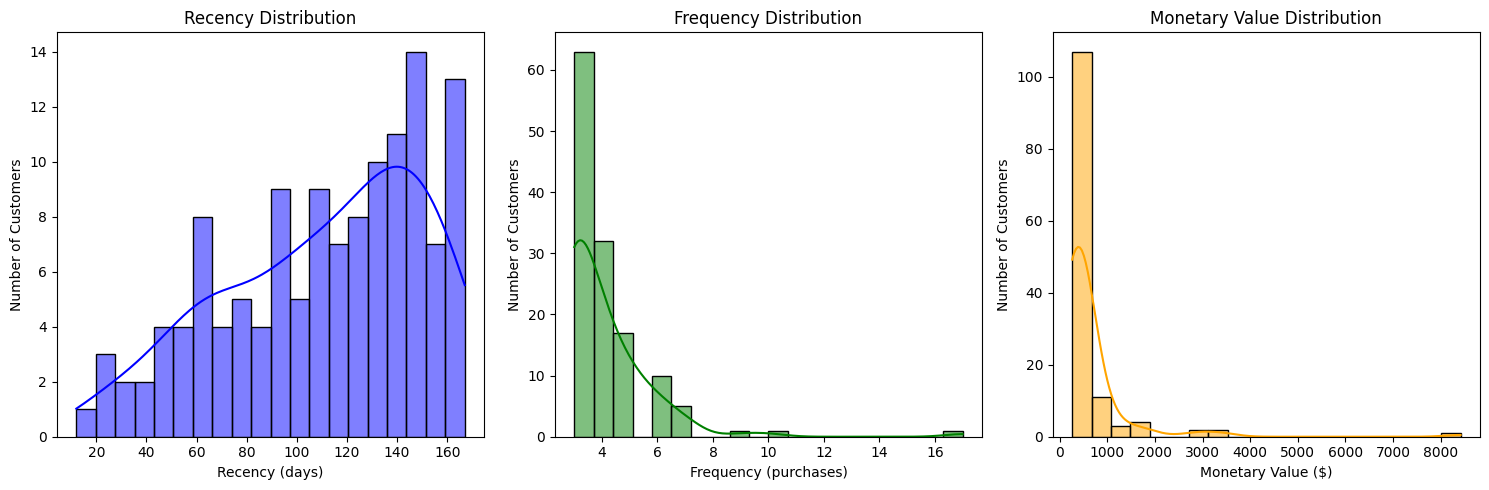

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(champions['recency'], bins=20, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Recency (days)')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 2)
sns.histplot(champions['frequency'], bins=20, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Frequency (purchases)')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 3)
sns.histplot(champions['monetary_value'], bins=20, kde=True, color='orange')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value ($)')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

- Recency: The recency distribution shows a wide spread with multiple peaks, suggesting that while many customers have recent interactions, there are also customers who haven't interacted in a while but are still valuable due to other factors like frequency or monetary value.

In [20]:
print(f"Total Revenue from Champions: ${champions['monetary_value'].sum():.2f}")

Total Revenue from Champions: $81308.40


In [21]:
num_champions = champions['Customer ID'].nunique()
total_customers = rfm_summary['Customer ID'].nunique()
percentage_champions = (num_champions / total_customers) * 100

print(f"Number of Champions: {num_champions}")
print(f"Percentage of Total Customers: {percentage_champions:.2f}%")

Number of Champions: 130
Percentage of Total Customers: 3.01%


In [22]:
merged_df = pd.merge(rfm_summary, df, on='Customer ID', how='inner')
merged_df.head(3)

,Customer ID,frequency,recency,T,monetary_value,R Score,F Score,M Score,RFM Score,Segment,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Country,Total Purchase
0,12346.0,6.0,196.0,360.0,47.143333,2,4,1,241,Not Categorized,491725,TEST001,This is a test product.,10,2009-12-14 08:34:00,4.5,United Kingdom,45.0
1,12346.0,6.0,196.0,360.0,47.143333,2,4,1,241,Not Categorized,491742,TEST001,This is a test product.,5,2009-12-14 11:00:00,4.5,United Kingdom,22.5
2,12346.0,6.0,196.0,360.0,47.143333,2,4,1,241,Not Categorized,491744,TEST001,This is a test product.,5,2009-12-14 11:02:00,4.5,United Kingdom,22.5


In [23]:
merged_df_champions = merged_df[merged_df['Segment'] == 'Champions']

##### Best-Selling Products

In [24]:
product_popularity = merged_df_champions.groupby('Description')['Quantity'].sum().reset_index()
product_popularity = product_popularity.sort_values(by='Quantity', ascending=False)

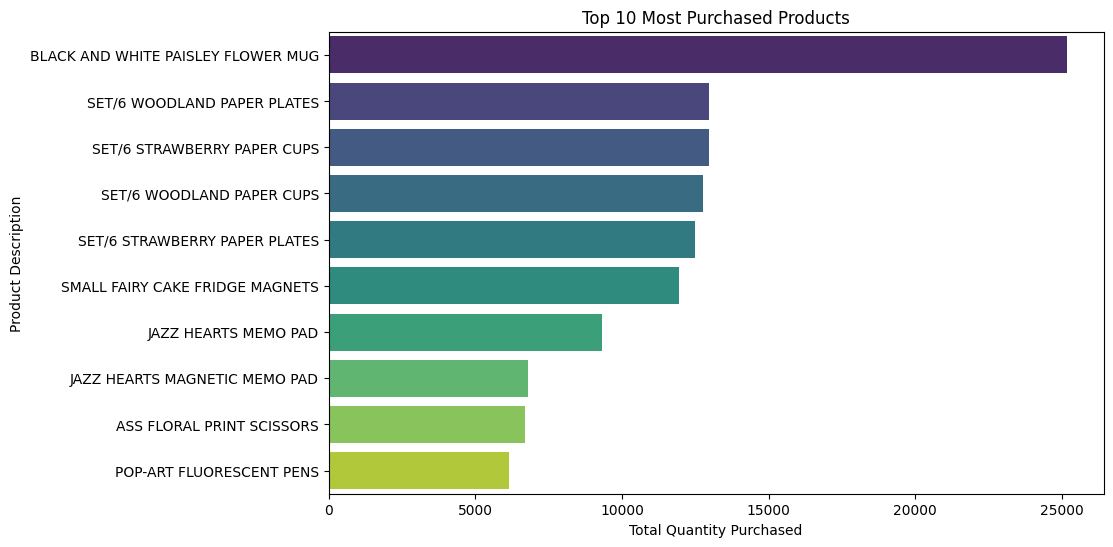

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x='Quantity', y='Description', data=product_popularity.head(10), palette='viridis')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Product Description')
plt.show()

##### Geographic Details

In [26]:
geographic_analysis = merged_df_champions.groupby('Country').agg({
    'Customer ID': 'nunique',
    'monetary_value': 'sum'
}).reset_index()

geographic_analysis.sort_values(by='monetary_value', ascending=False, inplace=True)
geographic_analysis

,Country,Customer ID,monetary_value
11,United Kingdom,115,8.031903e+06
9,Sweden,1,7.039485e+05
3,Germany,5,6.572744e+05
0,Australia,1,6.083375e+05
1,Denmark,1,5.302332e+05
6,Norway,1,5.042888e+05
10,Switzerland,1,2.864472e+05
4,Lithuania,1,1.635711e+05
2,France,1,1.224241e+05
8,Spain,1,7.014933e+04


##### Market Basket Analysis

In [27]:
# Creating a transaction matrix
basket = merged_df_champions.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')
''' The .unstack() function pivots the level of the Description labels, turning them from row indices into column headers.
This results in a DataFrame where each row represents an invoice, and each column represents a different product, with cell values as the total quantity of the product purchased in that invoice.'''
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
''' It converts the quantity values into 1s and 0s. A value of 1 indicates that the product was purchased in the respective invoice, while 0 means it was not.
This step prepares the data for the Apriori algorithm, which requires a transaction matrix in this format.'''

# Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.04, use_colnames=True)
''' These are groups of items that appear together in transactions with at least a certain minimum support level.
Support is the proportion of transactions that contain the itemset. '''

# Generating association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
'''This function generates association rules from the frequent itemsets. An association rule implies that if an item or items are purchased, another item is likely to be purchased.'''

# Top rules
rules.sort_values(by='lift', ascending=False).head(10)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
8,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.106684,0.056555,0.043702,0.409639,7.243154,1.0,0.037668,1.598080,0.964875,0.365591,0.374249,0.591183
9,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.056555,0.106684,0.043702,0.772727,7.243154,1.0,0.037668,3.930591,0.913608,0.365591,0.745585,0.591183
0,(HEART OF WICKER SMALL),(HEART OF WICKER LARGE),0.077121,0.097686,0.050129,0.650000,6.653947,1.0,0.042595,2.578039,0.920720,0.402062,0.612108,0.581579
1,(HEART OF WICKER LARGE),(HEART OF WICKER SMALL),0.097686,0.077121,0.050129,0.513158,6.653947,1.0,0.042595,1.895644,0.941705,0.402062,0.472475,0.581579
6,(WHITE HANGING HEART T-LIGHT HOLDER),(RED HANGING HEART T-LIGHT HOLDER),0.178663,0.073265,0.048843,0.273381,3.731415,1.0,0.035753,1.275408,0.891236,0.240506,0.215937,0.470024
7,(RED HANGING HEART T-LIGHT HOLDER),(WHITE HANGING HEART T-LIGHT HOLDER),0.073265,0.178663,0.048843,0.666667,3.731415,1.0,0.035753,2.464010,0.789875,0.240506,0.594158,0.470024
4,(WHITE HANGING HEART T-LIGHT HOLDER),(HOME BUILDING BLOCK WORD),0.178663,0.082262,0.044987,0.251799,3.060926,1.0,0.030290,1.226592,0.819763,0.208333,0.184733,0.399337
5,(HOME BUILDING BLOCK WORD),(WHITE HANGING HEART T-LIGHT HOLDER),0.082262,0.178663,0.044987,0.546875,3.060926,1.0,0.030290,1.812605,0.733653,0.208333,0.448308,0.399337
2,(WHITE HANGING HEART T-LIGHT HOLDER),(HEART OF WICKER LARGE),0.178663,0.097686,0.044987,0.251799,2.577622,1.0,0.027534,1.205977,0.745182,0.194444,0.170797,0.356162
3,(HEART OF WICKER LARGE),(WHITE HANGING HEART T-LIGHT HOLDER),0.097686,0.178663,0.044987,0.460526,2.577622,1.0,0.027534,1.522478,0.678307,0.194444,0.343176,0.356162


- Several rules exhibit high lift values, particularly those involving "Sweetheart Ceramic Trinket Box" and "Strawberry Ceramic Trinket Box", indicating that these items are more likely to be purchased together.
- Promotions: Items with strong associations can be jointly promoted to encourage bundled purchases.
- Product Placement: Strategically placing items next to each other in both physical and online stores can increase the likelihood of these items being purchased together.
- Cross-Selling Opportunities: Offering discounts on one item when the other is purchased at full price can capitalize on the natural tendency of these items to be bought together.

##### Time Series Analysis

In [29]:
merged_df_champions['InvoiceDate'] = pd.to_datetime(merged_df_champions['InvoiceDate'])

merged_df_champions.loc[:, "Month"] = merged_df_champions.InvoiceDate.dt.month
merged_df_champions.loc[:, "Time"] = merged_df_champions.InvoiceDate.dt.time
merged_df_champions.loc[:, "Year"] = merged_df_champions.InvoiceDate.dt.year
merged_df_champions.loc[:, "Day"] = merged_df_champions.InvoiceDate.dt.day
merged_df_champions.loc[:, "Quarter"] = merged_df_champions.InvoiceDate.dt.quarter
merged_df_champions.loc[:, "Day of Week"] = merged_df_champions.InvoiceDate.dt.dayofweek

#Mapping day of week
dayofweek_mapping = dict({0: "Monday",
                         1: "Tuesday",
                         2: "Wednesday" ,
                         3: "Thursday",
                         4: "Friday",
                         5: "Saturday",
                         6: "Sunday"})

merged_df_champions["Day of Week"] = merged_df_champions["Day of Week"].map(dayofweek_mapping)

<ipython-input-30-539929414bc2>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


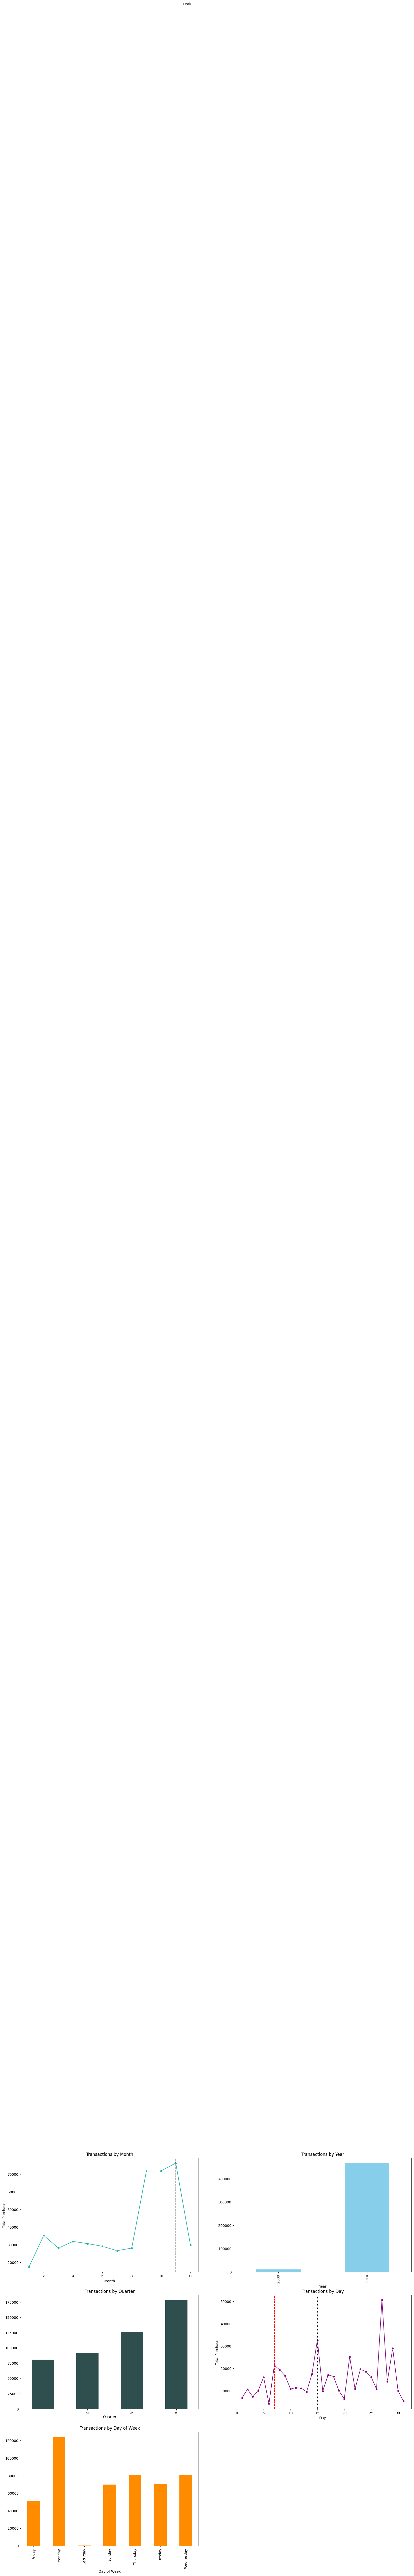

In [30]:
plt.figure(figsize=(20, 20))

plt.subplot(3,2,1)
sns.lineplot(x="Month", y="Total Purchase", data=merged_df_champions.groupby("Month")["Total Purchase"].sum().reset_index(), marker="o", color="lightseagreen")
plt.axvline(11, color="k", linestyle='--', alpha=0.3)
plt.text(11.5, 1.3e6, "Peak", verticalalignment='center')
plt.title("Transactions by Month")

plt.subplot(3,2,2)
merged_df_champions.groupby("Year")["Total Purchase"].sum().plot(kind="bar", color="skyblue")
plt.title("Transactions by Year")

plt.subplot(3,2,3)
merged_df_champions.groupby("Quarter")["Total Purchase"].sum().plot(kind="bar", color="darkslategrey")
plt.title("Transactions by Quarter")

plt.subplot(3,2,4)
day_data = merged_df_champions.groupby("Day")["Total Purchase"].sum().reset_index()
sns.lineplot(x="Day", y="Total Purchase", data=day_data, marker="o", color="purple")
plt.axvline(7, color='r', linestyle='--')
plt.axvline(15, color='k', linestyle="dotted")
plt.title("Transactions by Day")

plt.subplot(3,2,5)
merged_df_champions.groupby("Day of Week")["Total Purchase"].sum().plot(kind="bar", color="darkorange")
plt.title("Transactions by Day of Week")

plt.tight_layout()
plt.show()

- End-of-Year Sales Peak: There is a pronounced peak in purchase amounts towards the end of the year, likely driven by holiday season shopping events such as Black Friday, Cyber Monday, and Christmas. This trend is supported by the quarterly histogram, which shows elevated sales in the fourth quarter.

<ipython-input-31-5686f1656a04>:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


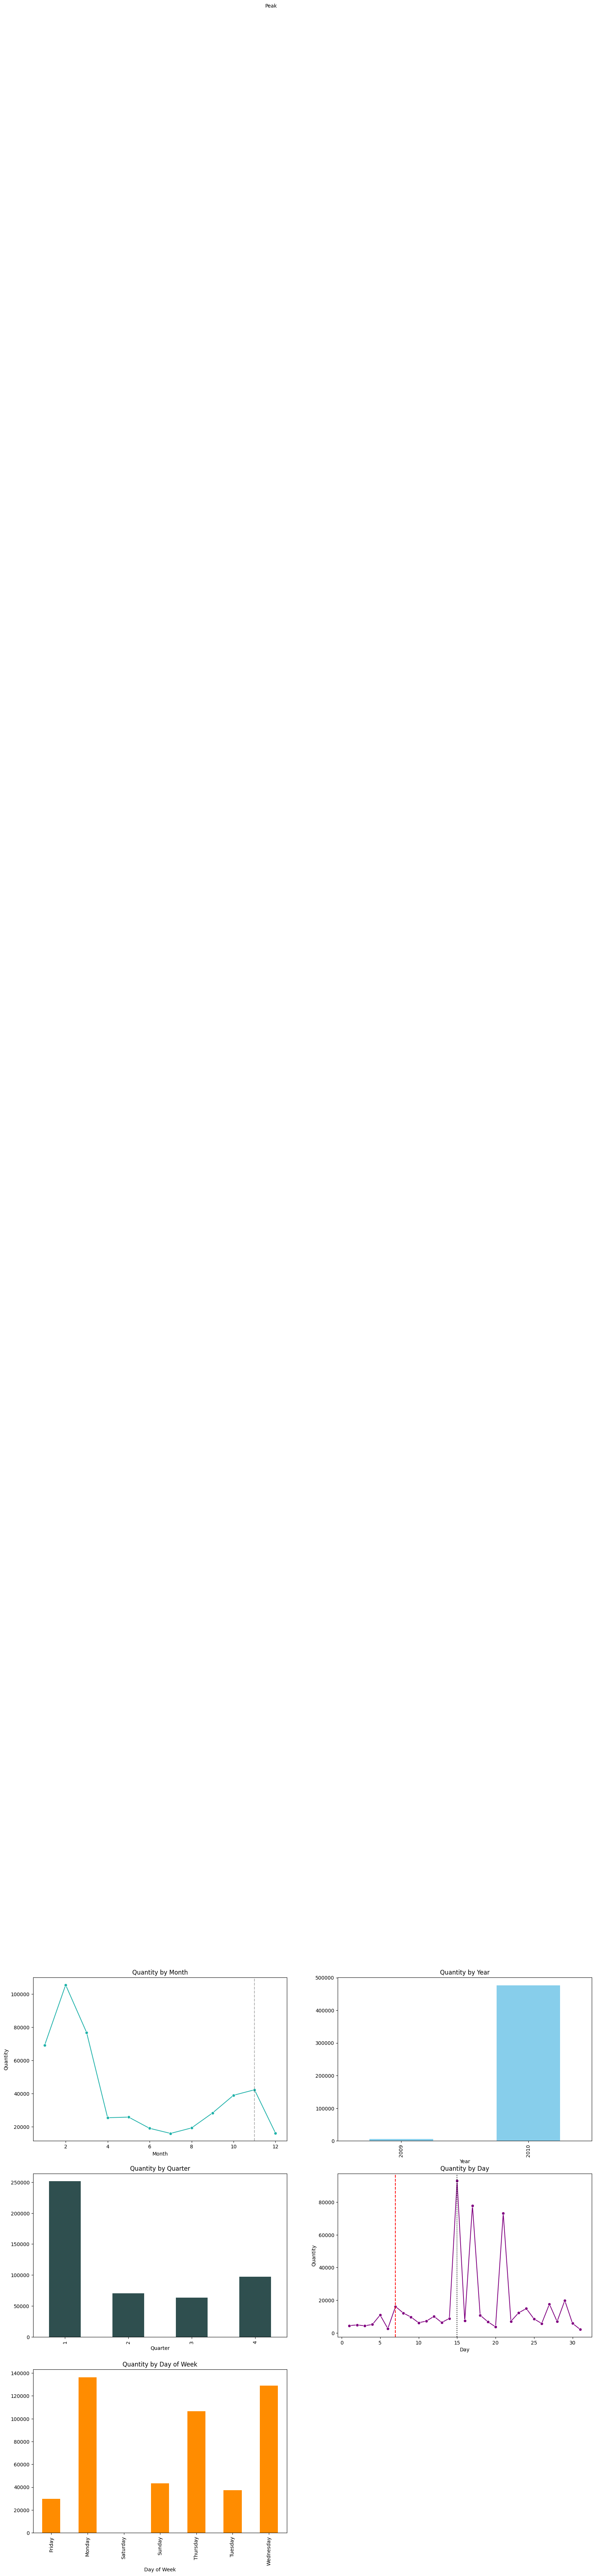

In [31]:
plt.figure(figsize=(20, 20))

plt.subplot(3,2,1)
sns.lineplot(x="Month", y="Quantity", data=merged_df_champions.groupby("Month")["Quantity"].sum().reset_index(), marker="o", color="lightseagreen")
plt.axvline(11, color="k", linestyle='--', alpha=0.3)
plt.text(11.5, 1.3e6, "Peak", verticalalignment='center')
plt.title("Quantity by Month")

plt.subplot(3,2,2)
merged_df_champions.groupby("Year")["Quantity"].sum().plot(kind="bar", color="skyblue")
plt.title("Quantity by Year")

plt.subplot(3,2,3)
merged_df_champions.groupby("Quarter")["Quantity"].sum().plot(kind="bar", color="darkslategrey")
plt.title("Quantity by Quarter")

plt.subplot(3,2,4)
day_data = merged_df_champions.groupby("Day")["Quantity"].sum().reset_index()
sns.lineplot(x="Day", y="Quantity", data=day_data, marker="o", color="purple")
plt.axvline(7, color='r', linestyle='--')
plt.axvline(15, color='k', linestyle="dotted")
plt.title("Quantity by Day")

plt.subplot(3,2,5)
merged_df_champions.groupby("Day of Week")["Quantity"].sum().plot(kind="bar", color="darkorange")
plt.title("Quantity by Day of Week")

plt.tight_layout()
plt.show()

#### 'Can't Lose Them' Segment Analysis

In [32]:
cant_lose_them = rfm_summary[rfm_summary['Segment'] == 'Can’t Lose Them']

In [33]:
cant_lose_them.describe()

,Customer ID,frequency,recency,T,monetary_value,R Score,F Score,M Score
count,534.000000,534.000000,534.000000,534.000000,534.000000,534.0,534.000000,534.000000
mean,15206.964419,10.374532,339.505618,356.786517,615.058586,1.0,3.779026,3.548689
std,1658.059645,11.432245,25.542132,20.738688,629.909590,0.0,0.415292,0.498090
min,12359.000000,3.000000,282.000000,282.000000,265.418000,1.0,3.000000,3.000000
25%,13843.500000,5.000000,318.000000,357.250000,338.960500,1.0,4.000000,3.000000
50%,15122.000000,7.000000,347.000000,365.000000,438.386667,1.0,4.000000,4.000000
75%,16680.500000,11.000000,360.000000,371.000000,648.332045,1.0,4.000000,4.000000
max,18276.000000,127.000000,373.000000,373.000000,8259.002619,1.0,4.000000,4.000000


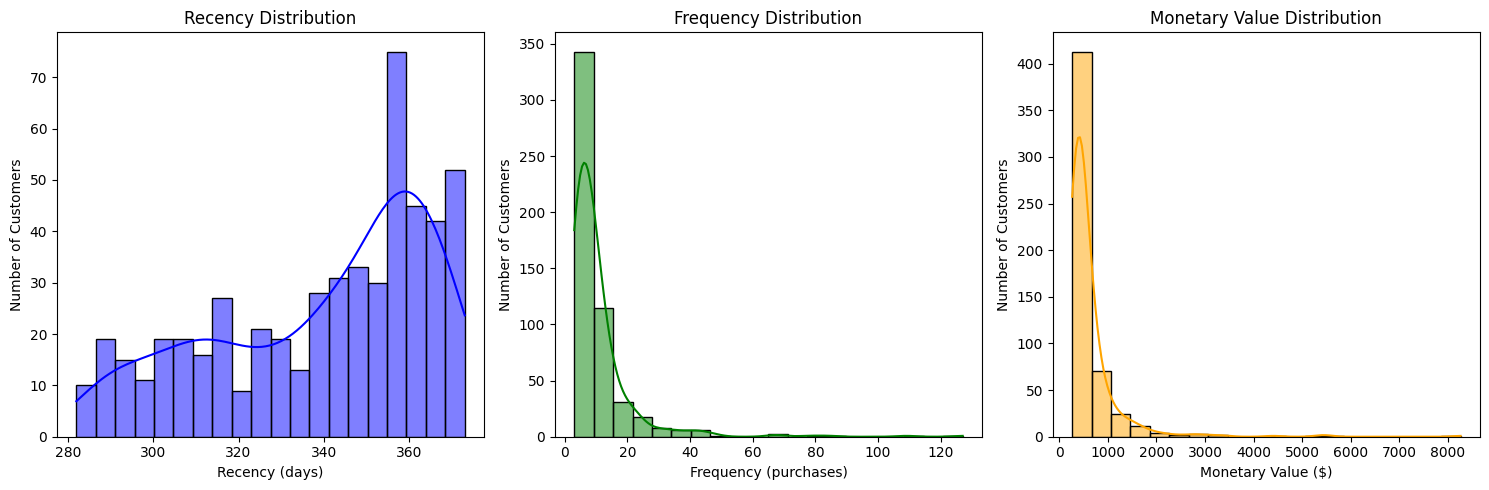

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
sns.histplot(cant_lose_them['recency'], bins=20, kde=True, color='blue')
plt.title('Recency Distribution')
plt.xlabel('Recency (days)')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 2)
sns.histplot(cant_lose_them['frequency'], bins=20, kde=True, color='green')
plt.title('Frequency Distribution')
plt.xlabel('Frequency (purchases)')
plt.ylabel('Number of Customers')

plt.subplot(1, 3, 3)
sns.histplot(cant_lose_them['monetary_value'], bins=20, kde=True, color='orange')
plt.title('Monetary Value Distribution')
plt.xlabel('Monetary Value ($)')
plt.ylabel('Number of Customers')

plt.tight_layout()
plt.show()

In [35]:
print(f"Total Revenue from Can't Lose Them: ${cant_lose_them['monetary_value'].sum():.2f}")

Total Revenue from Can't Lose Them: $328441.28


In [36]:
merged_df_clt = merged_df[merged_df['Segment'] == 'Can’t Lose Them']

##### Best-Selling Products

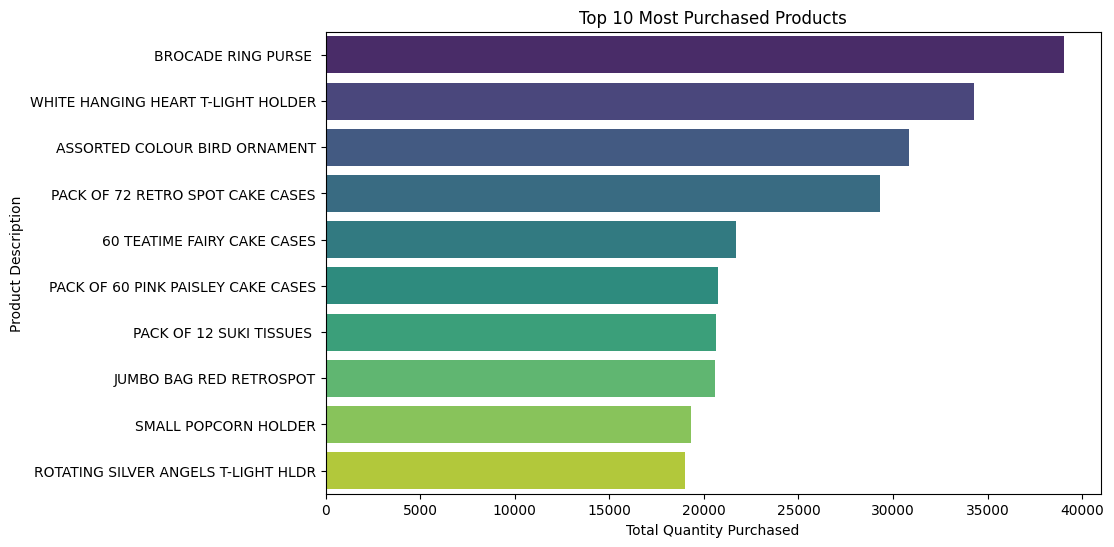

In [37]:
product_popularity_clt = merged_df_clt.groupby('Description')['Quantity'].sum().reset_index()
product_popularity_clt = product_popularity_clt.sort_values(by='Quantity', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Quantity', y='Description', data=product_popularity_clt.head(10), palette='viridis')
plt.title('Top 10 Most Purchased Products')
plt.xlabel('Total Quantity Purchased')
plt.ylabel('Product Description')
plt.show()

##### Market Basket Analysis

In [38]:
basket = merged_df_clt.groupby(['Invoice', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('Invoice')
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=0.5)
rules.sort_values(by='lift', ascending=False).head(10)

/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
10,(WOOD S/3 CABINET ANT WHITE FINISH),(WOOD 2 DRAWER CABINET WHITE FINISH),0.051317,0.043674,0.030981,0.603723,13.823379,1.0,0.028740,2.413279,0.977839,0.484009,0.585626,0.656549
11,(WOOD 2 DRAWER CABINET WHITE FINISH),(WOOD S/3 CABINET ANT WHITE FINISH),0.043674,0.051317,0.030981,0.709375,13.823379,1.0,0.028740,3.264285,0.970024,0.484009,0.693654,0.656549
6,(STRAWBERRY CERAMIC TRINKET BOX),(SWEETHEART CERAMIC TRINKET BOX),0.068377,0.040262,0.030981,0.453094,11.253622,1.0,0.028228,1.754849,0.978014,0.398946,0.430151,0.611293
7,(SWEETHEART CERAMIC TRINKET BOX),(STRAWBERRY CERAMIC TRINKET BOX),0.040262,0.068377,0.030981,0.769492,11.253622,1.0,0.028228,4.041599,0.949363,0.398946,0.752573,0.611293
14,(WOODEN FRAME ANTIQUE WHITE ),(WOODEN PICTURE FRAME WHITE FINISH),0.073427,0.057186,0.043674,0.594796,10.401114,1.0,0.039475,2.326762,0.975483,0.502355,0.570218,0.679259
15,(WOODEN PICTURE FRAME WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.057186,0.073427,0.043674,0.763723,10.401114,1.0,0.039475,3.921556,0.958679,0.502355,0.744999,0.679259
12,(WOODEN FRAME ANTIQUE WHITE ),(WOOD S/3 CABINET ANT WHITE FINISH),0.073427,0.051317,0.030708,0.418216,8.149643,1.0,0.026940,1.630644,0.946817,0.326560,0.386745,0.508310
13,(WOOD S/3 CABINET ANT WHITE FINISH),(WOODEN FRAME ANTIQUE WHITE ),0.051317,0.073427,0.030708,0.598404,8.149643,1.0,0.026940,2.307228,0.924751,0.326560,0.566579,0.508310
2,(LUNCH BAG RED SPOTTY),(LUNCH BAG BLACK SKULL.),0.072062,0.059096,0.030026,0.416667,7.050616,1.0,0.025767,1.612977,0.924812,0.296896,0.380029,0.462375
3,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED SPOTTY),0.059096,0.072062,0.030026,0.508083,7.050616,1.0,0.025767,1.886371,0.912068,0.296896,0.469882,0.462375


##### Geographic Details

In [39]:
geographic_analysis = merged_df_clt.groupby('Country').agg({
    'Customer ID': 'nunique',
    'monetary_value': 'sum'
}).reset_index()

geographic_analysis.sort_values(by='monetary_value', ascending=False, inplace=True)
geographic_analysis

,Country,Customer ID,monetary_value
14,United Kingdom,494,9.171236e+07
4,EIRE,3,1.354946e+07
9,Netherlands,3,9.744059e+06
5,France,10,2.955351e+06
6,Germany,12,2.648548e+06
11,Spain,3,2.331561e+05
12,Sweden,1,2.128194e+05
3,Denmark,1,1.288970e+05
7,Greece,1,1.247371e+05
13,Switzerland,2,1.017383e+05


#### Comparison of segments

In [40]:
# Compare average RFM metrics across segments
segment_summary = rfm_summary.groupby('Segment').agg({
    'recency': 'mean',
    'frequency': 'mean',
    'monetary_value': 'mean'
}).reset_index()

segment_summary

,Segment,recency,frequency,monetary_value
0,At-Risk Customers,332.945098,6.925490,270.303162
1,Can’t Lose Them,339.505618,10.374532,615.058586
2,Champions,110.907692,4.100000,625.449206
3,Hibernating,250.342857,1.123810,143.754619
4,Loyal Customers,191.402464,3.774127,393.582517
5,Not Categorized,129.313525,1.428279,499.326752
6,Recent Customers,12.458972,0.195295,24.187579


In [41]:
revenue_by_segment = rfm_summary.groupby('Segment')['monetary_value'].sum().reset_index()
revenue_by_segment['Percentage'] = (revenue_by_segment['monetary_value'] / revenue_by_segment['monetary_value'].sum()) * 100
revenue_by_segment = revenue_by_segment.sort_values(by='Percentage', ascending=False)
revenue_by_segment

,Segment,monetary_value,Percentage
4,Loyal Customers,383349.371995,32.905329
1,Can’t Lose Them,328441.284666,28.192217
5,Not Categorized,243671.455145,20.915880
2,Champions,81308.396827,6.979220
0,At-Risk Customers,68927.306290,5.916472
6,Recent Customers,44214.895000,3.795247
3,Hibernating,15094.235000,1.295635


- Loyal Customers: Contribute the most to the revenue (32.90%), underlining their economic importance despite not having the lowest recency or highest monetary value.
- Can't Lose Them: Despite their higher risk of churn (low recency), they contribute a significant 29.12% of the revenue, highlighting their previous value and potential if re-engaged effectively.
- Champions: Although they have excellent RFM scores, they represent only 6.97% of total revenue, suggesting a smaller but highly engaged customer base.

### Customer Segmentation using KNN

In [42]:
knn_data = merged_df.groupby('Customer ID').agg({
    'frequency': 'mean',
    'recency': 'mean',
    'T': 'mean',
    'monetary_value': 'mean',
    'R Score': 'mean',
    'F Score': 'mean',
    'M Score': 'mean',
    'RFM Score': 'first',
    'Quantity': 'sum',
    'Total Purchase': 'sum',
    'Country': 'first'
}).reset_index()

knn_data.head(3)

,Customer ID,frequency,recency,T,monetary_value,R Score,F Score,M Score,RFM Score,Quantity,Total Purchase,Country
0,12346.0,6.0,196.0,360.0,47.143333,2.0,4.0,1.0,241,70,372.86,United Kingdom
1,12347.0,1.0,37.0,39.0,711.790000,3.0,1.0,4.0,314,828,1323.32,Iceland
2,12348.0,0.0,0.0,73.0,0.000000,4.0,1.0,1.0,411,373,222.16,Finland


In [43]:
numerical_features = ['frequency','recency','T','monetary_value','Total Purchase']
categorical_features = ['Country']

# Creating a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(sparse_output=False), categorical_features)
    ])

X_processed = preprocessor.fit_transform(knn_data)

processed_columns = numerical_features + list(preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features))
X_processed_df = pd.DataFrame(X_processed, columns=processed_columns)
X_processed_df.head(3)

,frequency,recency,T,monetary_value,Total Purchase,Country_Australia,Country_Austria,Country_Bahrain,Country_Belgium,Country_Brazil,...,Country_Singapore,Country_Spain,Country_Sweden,Country_Switzerland,Country_Thailand,Country_USA,Country_United Arab Emirates,Country_United Kingdom,Country_Unspecified,Country_West Indies
0,0.508322,0.464256,1.139540,-0.536639,-0.187074,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.322511,-0.731392,-1.560672,1.063453,-0.080386,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.488678,-1.009624,-1.274668,-0.650133,-0.203990,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


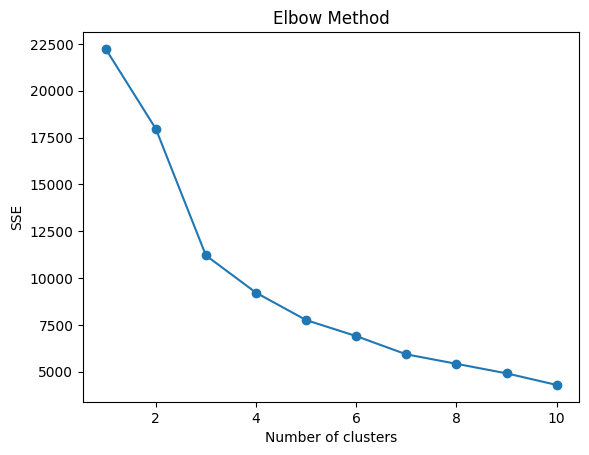

In [44]:
# Determining the optimal number of clusters using the Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed_df)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.title('Elbow Method')
plt.show()

In [45]:
kmeans = KMeans(n_clusters=3, random_state=42)
knn_data['Cluster'] = kmeans.fit_predict(X_processed)

knn_data[['Customer ID', 'Cluster']]

,Customer ID,Cluster
0,12346.0,1
1,12347.0,0
2,12348.0,0
3,12349.0,1
4,12351.0,0
...,...,...
4309,18283.0,1
4310,18284.0,0
4311,18285.0,0
4312,18286.0,1


In [46]:
knn_data.head(3)

,Customer ID,frequency,recency,T,monetary_value,R Score,F Score,M Score,RFM Score,Quantity,Total Purchase,Country,Cluster
0,12346.0,6.0,196.0,360.0,47.143333,2.0,4.0,1.0,241,70,372.86,United Kingdom,1
1,12347.0,1.0,37.0,39.0,711.790000,3.0,1.0,4.0,314,828,1323.32,Iceland,0
2,12348.0,0.0,0.0,73.0,0.000000,4.0,1.0,1.0,411,373,222.16,Finland,0


In [47]:
# Analyzing the clusters
features = ['frequency','recency','T','monetary_value','Total Purchase']

cluster_profiles = knn_data.groupby('Cluster')[features].mean()
cluster_profiles

,frequency,recency,T,monetary_value,Total Purchase
Cluster,,,,,
0,0.649620,28.061285,148.916737,103.391213,571.139579
1,5.178367,262.303692,315.879875,445.177118,2813.270827
2,47.680000,336.160000,354.280000,2572.309498,81479.908000


- Cluster 0 has the lowest mean frequency and recency (mean around 28 days). These customers have engaged recently but do so very infrequently. Both monetary value (around 103.39) and total purchases (around 571.14) are the lowest among the clusters, indicating that these customers spend the least both per transaction and overall. These might be new customers or occasional buyers who have not yet fully engaged with the brand.
- Cluster 1 has a moderate frequency and comparitively higher recency of 262 days, these customers purchase more frequently than those in Cluster 0 but have not made purchases recently. Their average monetary value per transaction is higher (around 445.17), and their total purchases are considerably more substantial (around 2813.27) than those in Cluster 0. This cluster represents potentially loyal customers who have not shopped recently. Re-engagement strategies such as loyalty programs or targeted promotions based on previous purchase patterns could reactivate their purchasing.
- Cluster 2 features the highest frequency and a moderate recency of about 336 days. The high frequency suggests very frequent interactions despite the longer recency. They have the highest monetary value and total purchases, indicating that these customers are both frequent and high spenders. These are the most valuable customers, likely VIPs or heavy users, whose continued engagement is crucial. Maintaining satisfaction and loyalty through exclusive offers, premium services, and personalized communication is key.

### Predicting future purchase frequency, profit and CLV

#### Predicting future purchase frequency

In [48]:
# Fitting the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(knn_data['frequency'], knn_data['recency'], knn_data['T'])

# Predict expected purchases for the next period (90 days)
knn_data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(90, knn_data['frequency'], knn_data['recency'], knn_data['T'])

In [49]:
knn_data[['frequency', 'recency', 'T', 'predicted_purchases']].head()

,frequency,recency,T,predicted_purchases
0,6.0,196.0,360.0,1.382538
1,1.0,37.0,39.0,1.522529
2,0.0,0.0,73.0,0.543839
3,2.0,182.0,224.0,0.872839
4,0.0,0.0,10.0,0.964167


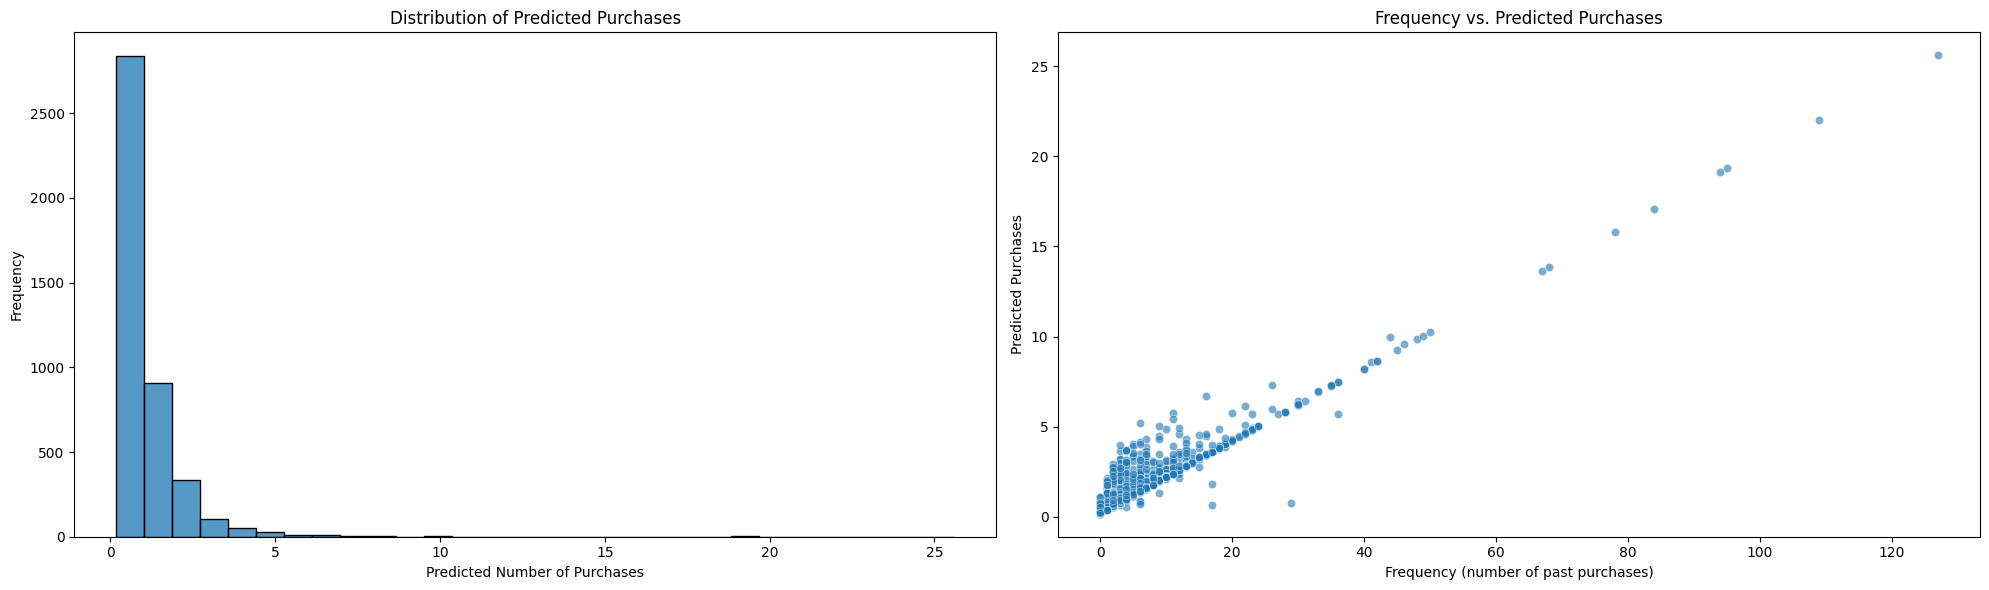

In [50]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.histplot(knn_data['predicted_purchases'], bins=30, kde=False)
plt.title('Distribution of Predicted Purchases')
plt.xlabel('Predicted Number of Purchases')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(data=knn_data, x='frequency', y='predicted_purchases', alpha=0.6)
plt.title('Frequency vs. Predicted Purchases')
plt.xlabel('Frequency (number of past purchases)')
plt.ylabel('Predicted Purchases')

plt.tight_layout()
plt.show()

- Using the BG/NBD model, we can get the expected number of purchases for each customer in the next 90 days. The model specifically uses frequency, recency, and T to make predictions.
- The distribution of the predicted number of purchases shows that most customers are predicted to make a small number of purchases (likely between 0 and 5), with the frequency decreasing as the number of predicted purchases increases.This suggests that the majority of customers are expected to make few purchases.
- The scatter plot between frequency and predicted future purchases shows a positive correlation, i.e, customers with higher past purchase frequencies are predicted to make more future purchases.This indicates that customers who have purchased more frequently in the past are expected to continue doing so.

Strategies
- Customers can be segmented based on their predicted purchase behavior.
- Targeted Marketing: Focus marketing efforts on customers with high predicted purchases, especially those with recent purchases and past high purchase frequencies.
- Retention Strategies: For customers with low predicted purchases, considering re-engagement strategies is a good option to increase their purchase likelihood.

#### Predicting Profit and CLV

In [51]:
repeat_customers = knn_data[knn_data['frequency'] > 0]

ggf = GammaGammaFitter(penalizer_coef=0.0)
ggf.fit(repeat_customers['frequency'], repeat_customers['monetary_value'])

knn_data['predicted_profit'] = ggf.conditional_expected_average_profit(
    knn_data['frequency'],
    knn_data['monetary_value']
)

# Calculating CLV over the next 3 months
# Assuming a monthly discount rate of 1% (which is a yearly rate of about 12.7%)
discount_rate = 0.01
knn_data['CLV'] = ggf.customer_lifetime_value(
    bgf,
    knn_data['frequency'],
    knn_data['recency'],
    knn_data['T'],
    knn_data['predicted_profit'],
    time=3,
    discount_rate=discount_rate
)

In [52]:
knn_data[['frequency', 'monetary_value', 'predicted_profit']].head()

,frequency,monetary_value,predicted_profit
0,6.0,47.143333,108.175978
1,1.0,711.790000,554.413179
2,0.0,0.000000,420.282058
3,2.0,801.310000,660.427803
4,0.0,0.000000,420.282058


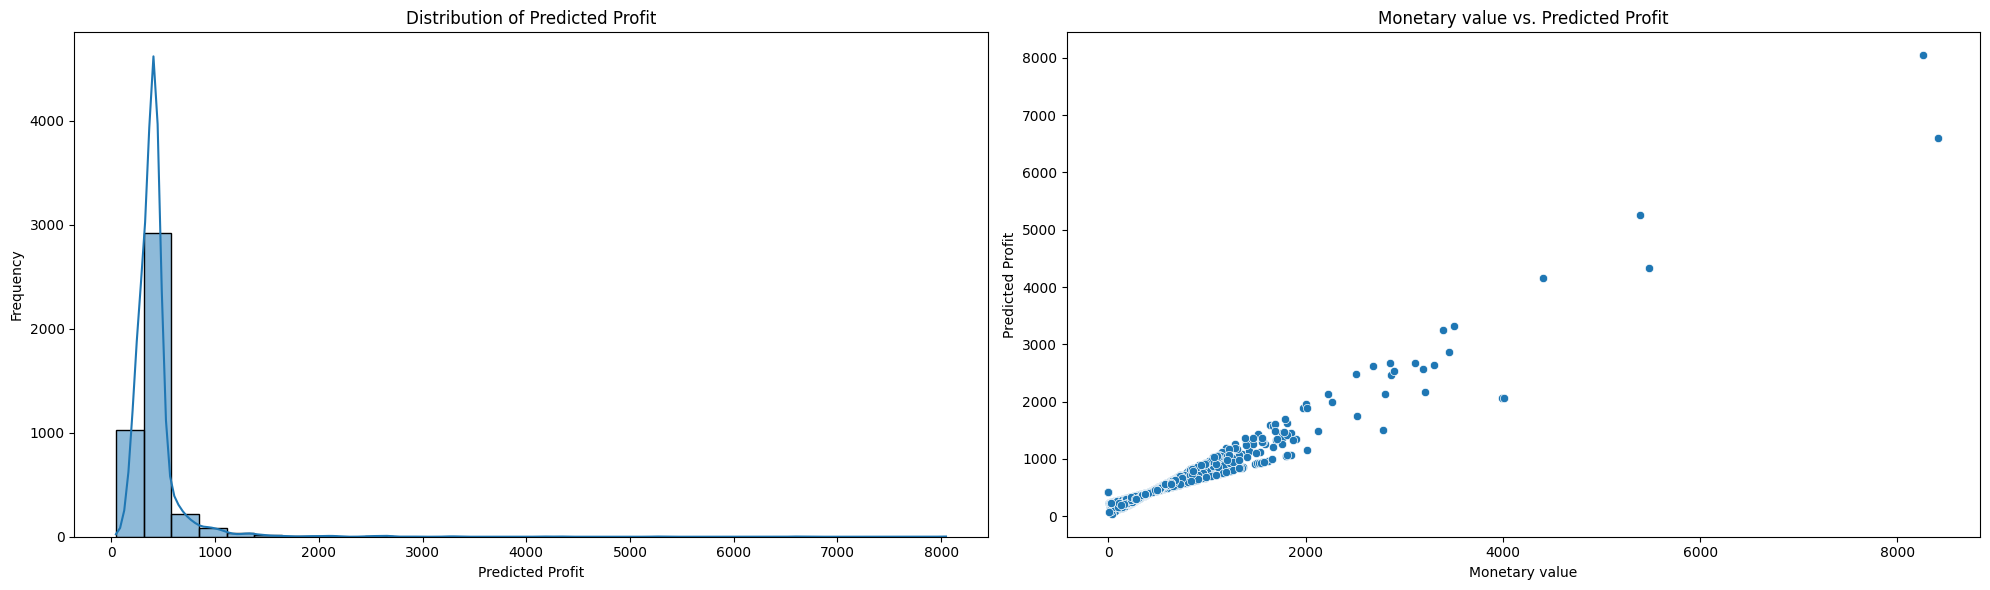

In [53]:
plt.figure(figsize=(20, 6))

plt.subplot(1, 2, 1)
sns.histplot(knn_data['predicted_profit'], bins=30, kde=True)
plt.title('Distribution of Predicted Profit')
plt.xlabel('Predicted Profit')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x='monetary_value', y='predicted_profit', data=knn_data)
plt.title('Monetary value vs. Predicted Profit')
plt.xlabel('Monetary value')
plt.ylabel('Predicted Profit')

plt.tight_layout()
plt.show()

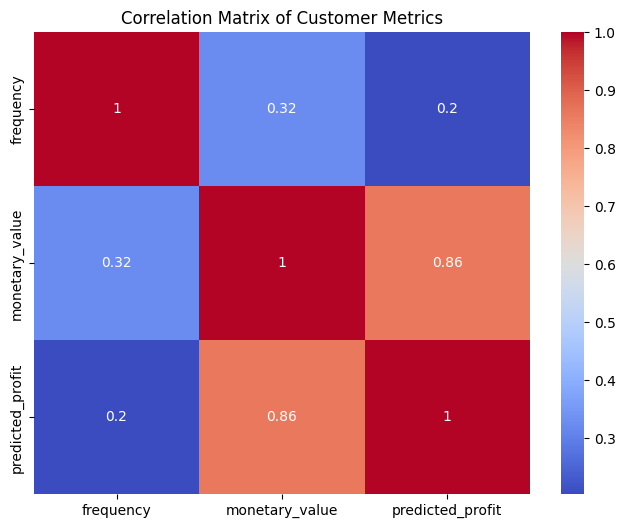

In [54]:
corr_matrix = knn_data[['frequency', 'monetary_value', 'predicted_profit']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Customer Metrics')
plt.show()

- Distribution of Predicted Profit: The histogram shows that the majority of predicted profits are concentrated in the lower range (0 to 2000), with fewer customers generating higher predicted profits.
- The scatter plot shows a positive correlation between monetary value and predicted profit. As the monetary value of purchases increases, the predicted profit also tends to increase. This is also supported by the correlation matrix as there is a strong positive correlation (around 0.86) between monetary value and predicted profit.

Strategy:
- Customer Segmentation: Identify and segment customers based on their predicted profits. Customers with high monetary values are likely the most valuable. They should be targeted for retention, loyalty programs and upselling strategies.

- Targeted Marketing: Focus on customers with high monetary values but lower frequencies to increase their purchase frequency, thereby boosting their predicted profits.

In [55]:
knn_data[['frequency', 'recency', 'T', 'predicted_profit', 'CLV']].head()

,frequency,recency,T,predicted_profit,CLV
0,6.0,196.0,360.0,108.175978,215.806243
1,1.0,37.0,39.0,554.413179,719.427338
2,0.0,0.0,73.0,420.282058,224.070144
3,2.0,182.0,224.0,660.427803,489.132445
4,0.0,0.0,10.0,420.282058,397.253078


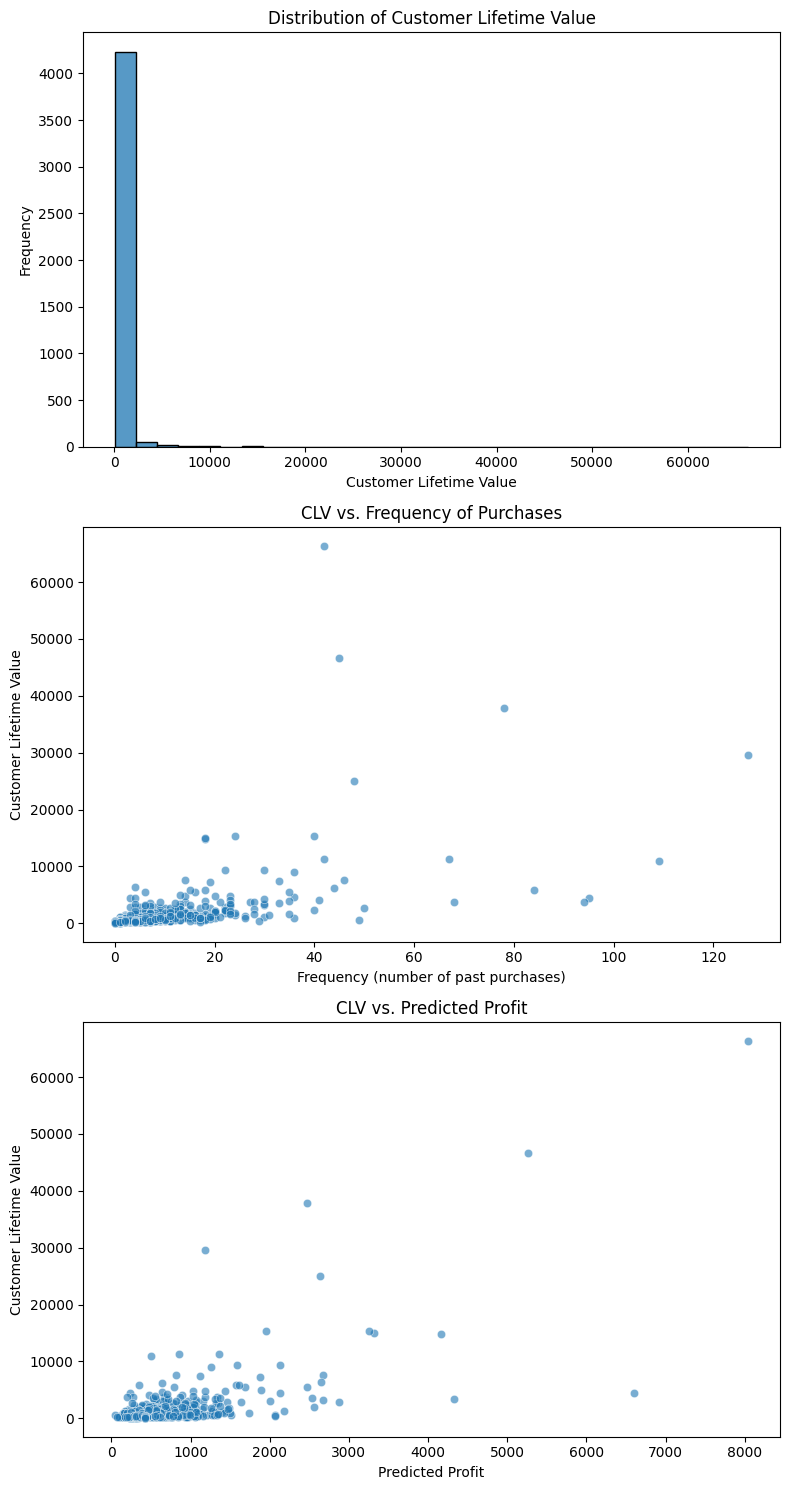

In [56]:
plt.figure(figsize=(8, 15))

plt.subplot(3, 1, 1)
sns.histplot(knn_data['CLV'], bins=30, kde=False)
plt.title('Distribution of Customer Lifetime Value')
plt.xlabel('Customer Lifetime Value')
plt.ylabel('Frequency')

plt.subplot(3, 1, 2)
sns.scatterplot(data=knn_data, x='frequency', y='CLV', alpha=0.6)
plt.title('CLV vs. Frequency of Purchases')
plt.xlabel('Frequency (number of past purchases)')
plt.ylabel('Customer Lifetime Value')

plt.subplot(3, 1, 3)
sns.scatterplot(data=knn_data, x='predicted_profit', y='CLV', alpha=0.6)
plt.title('CLV vs. Predicted Profit')
plt.xlabel('Predicted Profit')
plt.ylabel('Customer Lifetime Value')

plt.tight_layout()
plt.show()

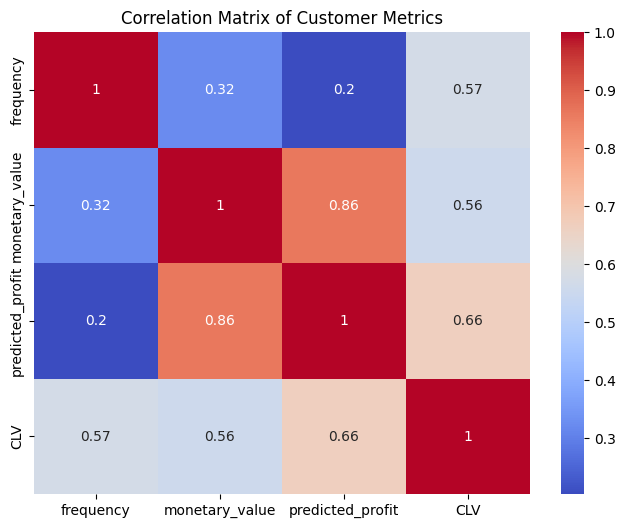

In [57]:
corr_matrix = knn_data[['frequency', 'monetary_value', 'predicted_profit', 'CLV']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix of Customer Metrics')
plt.show()

- The scatter plot shows a positive correlation between the frequency of purchases and CLV. Customers with higher purchase frequencies tend to have higher CLVs.
 - There is variability in CLV even among customers with similar frequencies, indicating that other factors (like monetary value and recency) also play a significant role in determining CLV.

- The scatter plot suggests a positive correlation between predicted profit and CLV. Customers with higher predicted profits tend to have higher CLVs.

- The histogram shows that the majority of CLVs are concentrated in the lower range (0 to 20000), with fewer customers having significantly higher CLVs.

- The insights above are supported by the correlation matrix. There is a moderate to strong positive correlation between CLV and frequency, monetary value, predicted_profit.  

Strategy:
- Customer Segmentation: Identify and segment customers based on their CLV and predicted profits. High-CLV customers should be targeted for retention and loyalty programs.

- Targeted Marketing: Focus on customers with moderate CLVs to move them into higher CLV segments.

### Churn Rate

In [59]:
# Defining the end of the period for the churn analysis
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
last_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)

# Number of days since last purchase and stored it in 'InvoiceDate' column
customer_data = df.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (last_date - x.max()).days
})

# churn: customers who haven't purchased in the last 90 days
churn_threshold = 90
customer_data['churned'] = customer_data['InvoiceDate'] > churn_threshold

churn_rate = customer_data['churned'].mean() * 100
print(f'Churn Rate: {churn_rate:.2f}%')

Churn Rate: 33.31%


### Survival Analysis

The Kaplan-Meier Estimator is primarily used in survival analysis to measure the time until a customer "churns" or stops engaging with the business.

/usr/local/lib/python3.11/dist-packages/lifelines/fitters/kaplan_meier_fitter.py:450: DeprecationWarning: The `plot` function is deprecated, and will be removed in future versions. Use `plot_survival_function`
  warnings.warn(


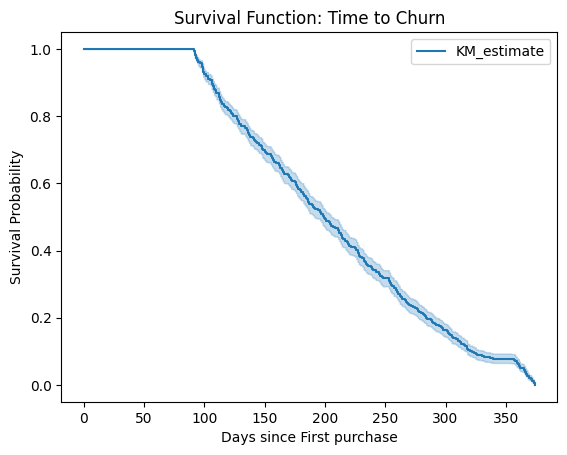

In [60]:
customer_data.rename(columns={'InvoiceDate': 'Duration'}, inplace=True)
customer_data['Event'] = customer_data['churned'].astype(int)

# Kaplan-Meier Estimator
kmf = KaplanMeierFitter()
kmf.fit(durations=customer_data['Duration'], event_observed=customer_data['Event'])

# Plot the survival function
kmf.plot()
plt.title('Survival Function: Time to Churn')
plt.xlabel('Days since First purchase')
plt.ylabel('Survival Probability')
plt.show()

- Interpretation:
  - Starting at 100%: The curve starts at 100% survival probability, meaning initially, all customers are considered active.
  - Steady Decline: As time progresses, the survival probability steadily declines, which means more customers are churning as days increase. At around 125 days, the survival probability is just under 80%. This implies that about 20% of customers have churned within the first 125 days.
- Customer Retention Strategies: Identify critical time points where the survival probability sharply decreases and implement targeted interventions to engage customers before they reach these churn probabilities.